In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
import random
from sklearn.utils import shuffle

['glioma', 'meningioma', 'notumor', 'pituitary']
glioma 1321
meningioma 1339
notumor 1595
pituitary 1457


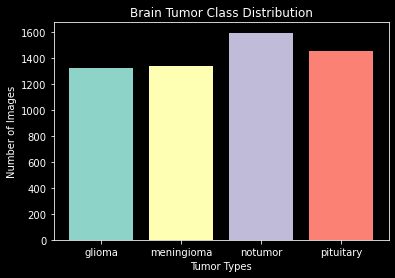

In [2]:
dirpath = "C:/Users/Administrator/Desktop/dataset1/Training"
tumor_labels = os.listdir(dirpath)
print(tumor_labels)
# find how many images are there in each label and plot a bar chart and give approprita title and labels
for label in tumor_labels:
    print(label, len(os.listdir(dirpath + "/" + label)))
    plt.bar(label, len(os.listdir(dirpath + "/" + label)))
    plt.title("Brain Tumor Class Distribution")
    plt.xlabel("Tumor Types")
    plt.ylabel("Number of Images")


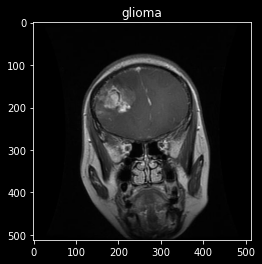

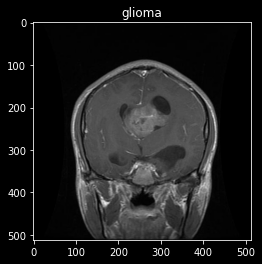

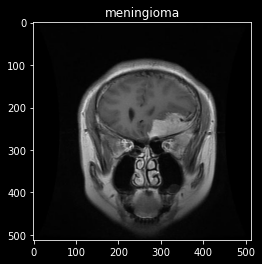

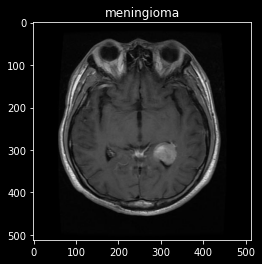

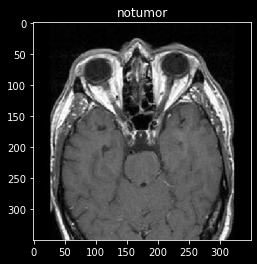

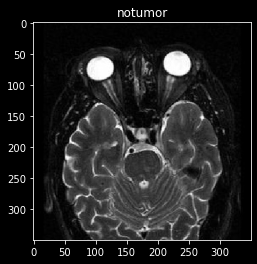

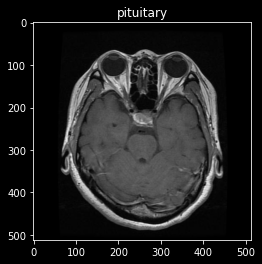

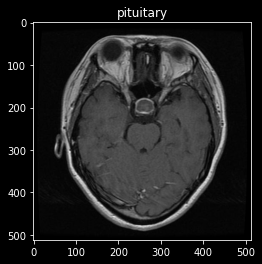

In [3]:
# plot some of the images
for label in tumor_labels:
    for img in os.listdir(dirpath + "/" + label)[:2]:
        img_array = cv2.imread(dirpath + "/" + label + "/" + img, cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        plt.title(label)
        plt.show()

In [4]:
from sklearn.model_selection import train_test_split
batch_size = 24
epochs = 12
learning_rate = 0.001
# create x_train y_train and x_val y_val, use cv2 to read
x_train = []
y_train = []
for label in tumor_labels:
    for img in os.listdir(dirpath + "/" + label):
        img_array = cv2.imread(dirpath + "/" + label + "/" + img, cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (256,256))
        img_array = np.expand_dims(img_array, axis=2)
        x_train.append(img_array)
        y_train.append(tumor_labels.index(label))

x_train = np.array(x_train)
y_train = np.array(y_train)

y_train = tf.keras.utils.to_categorical(y_train)
x_train, y_train = shuffle(x_train,y_train)

In [5]:
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential

# Let us create the model
model = Sequential()
model.add(tf.keras.Input(shape=(256, 256, 1)))

model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3) , strides = (2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3) , strides = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3) , strides = (2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dense(len(tumor_labels), activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 125, 125, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 61, 61, 64)        0

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=1, min_lr=0.00001, verbose = 1)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
checkpoint = ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[reduce_lr, early_stopping, checkpoint])

Epoch 1/12
191/191 [==============================] - ETA: 0s - loss: 7.0317 - accuracy: 0.5192
Epoch 1: val_loss improved from inf to 0.87550, saving model to model.h5
191/191 [==============================] - 13s 54ms/step - loss: 7.0317 - accuracy: 0.5192 - val_loss: 0.8755 - val_accuracy: 0.6623 - lr: 0.0010
Epoch 2/12
190/191 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.7397
Epoch 2: val_loss improved from 0.87550 to 0.53231, saving model to model.h5
191/191 [==============================] - 10s 51ms/step - loss: 0.6760 - accuracy: 0.7398 - val_loss: 0.5323 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 3/12
191/191 [==============================] - ETA: 0s - loss: 0.4631 - accuracy: 0.8396
Epoch 3: val_loss improved from 0.53231 to 0.39706, saving model to model.h5
191/191 [==============================] - 11s 55ms/step - loss: 0.4631 - accuracy: 0.8396 - val_loss: 0.3971 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 4/12
191/191 [===========================

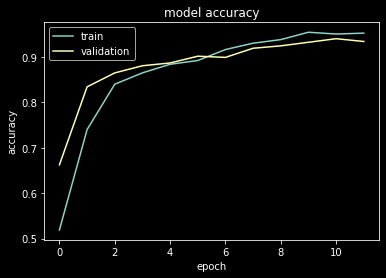

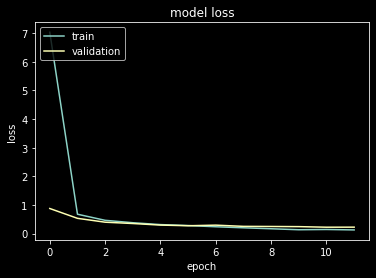

In [7]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [8]:
# load the model.h5
model = tf.keras.models.load_model('model.h5')
#save the model
model.save('detect_tumor_model')

INFO:tensorflow:Assets written to: detect_tumor_model\assets


In [9]:
# load the model
from tensorflow.keras.models import load_model
model = load_model('detect_tumor_model')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 125, 125, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 61, 61, 64)        0

In [10]:
# use the model to predict 
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

# test the model with testing model
test_dirpath = "C:/Users/Administrator/Desktop/dataset1/Testing"
test_labels = os.listdir(test_dirpath)
total_samples = 0
correct_predictions = 0
for label in test_labels:
    for img in tqdm(os.listdir(test_dirpath + "/" + label)):
        img_array = cv2.imread(test_dirpath + "/" + label + "/" + img , cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (256,256))
        img_array = np.expand_dims(img_array, axis=0)
        img_array = np.expand_dims(img_array, axis=3)
        prediction = model.predict(img_array)
        predicted_label = test_labels[np.argmax(prediction)]
        total_samples += 1
        if predicted_label == label:
            correct_predictions += 1


print(correct_predictions)
print(total_samples)
print("Accuracy of the model on test data is ", correct_predictions/total_samples)

100%|██████████| 300/300 [00:16<00:00, 18.30it/s]

1213
1311
Accuracy of the model on test data is  0.9252479023646072


In [11]:
test_labels

['glioma', 'meningioma', 'notumor', 'pituitary']

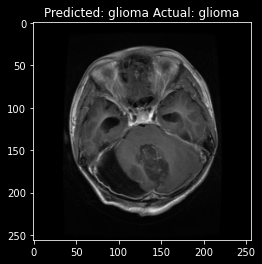

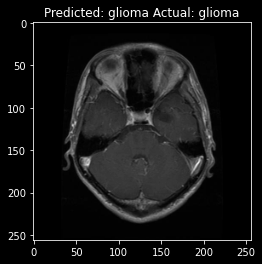

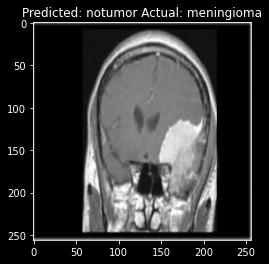

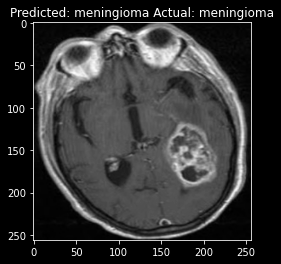

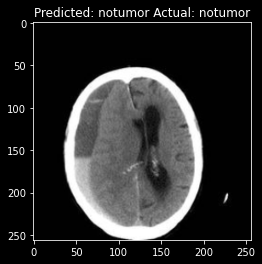

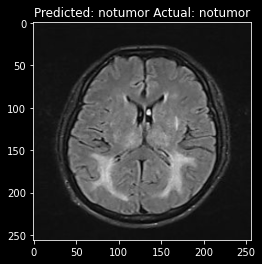

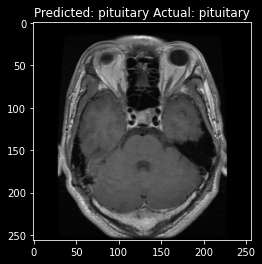

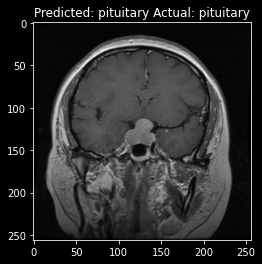

In [29]:
# randomly select one image from each label and test using the model
import random
for label in test_labels:
    for img in os.listdir(test_dirpath + "/" + label)[:2]:
        img_array = cv2.imread(test_dirpath + "/" + label + "/" + img , cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (256,256))
        img_array = np.expand_dims(img_array, axis=0)
        img_array = np.expand_dims(img_array, axis=3)

        prediction = model.predict(img_array)
        predicted_label = test_labels[np.argmax(prediction)]
        plt.imshow(img_array[0], cmap='gray')
        plt.title("Predicted: " + predicted_label + " Actual: " + label)
        plt.show()
            